<a href="https://colab.research.google.com/github/Quaser001/scribbles_ml/blob/main/ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:

import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split



In [3]:
# Paths
data_dir = "/content/drive/MyDrive/xAIDataset"

# Make a dict for clarity
classes = {
    "T1 HC images": 0,
    "T2 HC images": 0,
    "T1 PD images": 1,
    "T2 PD images": 1
}

# Collect all image paths + labels
image_paths = []
labels = []

for folder, label in classes.items():
    folder_path = os.path.join(data_dir, folder)
    files = glob.glob(folder_path + "/*.png")
    image_paths.extend(files)
    labels.extend([label]*len(files))

print("Total images:", len(image_paths))
print("Class distribution:", np.bincount(labels))



Total images: 4134
Class distribution: [1130 3004]


In [4]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, stratify=train_labels, random_state=42)


In [5]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class ParkinsonsDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        img = plt.imread(img_path)
        if len(img.shape) == 2: # grayscale → 3 channels
            img = np.stack([img]*3, axis=-1)
        img = transforms.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        return img, label

# Datasets
train_ds = ParkinsonsDataset(train_paths, train_labels, train_transform)
val_ds = ParkinsonsDataset(val_paths, val_labels, val_test_transform)
test_ds = ParkinsonsDataset(test_paths, test_labels, val_test_transform)

# Loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained
model = models.resnet50(pretrained=True)

# Freeze most layers
for name, param in model.named_parameters():
    param.requires_grad = False

# Unfreeze last 2 layers (layer4 and fc)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Replace classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Binary classification

model = model.to(device)

# Loss & optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

# Force device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_model(model, train_loader, val_loader, epochs=10):
    best_val_auc = 0.0
    model.to(device)  # move model to GPU/CPU

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # --- Training loop ---
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- Validation loop ---
        model.eval()
        y_true, y_pred, y_score = [], [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(imgs)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).int()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_score.extend(probs.cpu().numpy())

        # --- Metrics ---
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        auc = roc_auc_score(y_true, y_score)

        # --- Print epoch summary ---
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | "
              f"F1: {f1:.4f} | AUC: {auc:.4f}")

        # --- Save best model ---
        if auc > best_val_auc:
            best_val_auc = auc
            torch.save(model.state_dict(), "best_resnet50.pth")
            print(f"✅ Saved new best model (AUC: {best_val_auc:.4f})")

# Run training
train_model(model, train_loader, val_loader, epochs=15)


Using device: cuda
[Epoch 1/15] Train Loss: 0.4582 | Val Acc: 0.8308 | Prec: 0.8685 | Rec: 0.9046 | F1: 0.8862 | AUC: 0.8690
✅ Saved new best model (AUC: 0.8690)
[Epoch 2/15] Train Loss: 0.3309 | Val Acc: 0.8731 | Prec: 0.8902 | Rec: 0.9419 | F1: 0.9153 | AUC: 0.9331
✅ Saved new best model (AUC: 0.9331)
[Epoch 3/15] Train Loss: 0.2760 | Val Acc: 0.9184 | Prec: 0.8993 | Rec: 1.0000 | F1: 0.9470 | AUC: 0.9679
✅ Saved new best model (AUC: 0.9679)
[Epoch 4/15] Train Loss: 0.2244 | Val Acc: 0.9094 | Prec: 0.9451 | Rec: 0.9295 | F1: 0.9372 | AUC: 0.9678
[Epoch 5/15] Train Loss: 0.1842 | Val Acc: 0.9396 | Prec: 0.9368 | Rec: 0.9834 | F1: 0.9595 | AUC: 0.9733
✅ Saved new best model (AUC: 0.9733)
[Epoch 6/15] Train Loss: 0.1703 | Val Acc: 0.9426 | Prec: 0.9269 | Rec: 1.0000 | F1: 0.9621 | AUC: 0.9903
✅ Saved new best model (AUC: 0.9903)
[Epoch 7/15] Train Loss: 0.1474 | Val Acc: 0.9396 | Prec: 0.9510 | Rec: 0.9668 | F1: 0.9588 | AUC: 0.9808
[Epoch 8/15] Train Loss: 0.1289 | Val Acc: 0.9215 | Pr

[Epoch 1/15] Train Loss: 0.5271 | Val Acc: 0.8278 | Prec: 0.8172 | Rec: 0.9834 | F1: 0.8927 | AUC: 0.8669
✅ Saved new best model (AUC: 0.8669)
[Epoch 2/15] Train Loss: 0.3875 | Val Acc: 0.8278 | Prec: 0.8087 | Rec: 1.0000 | F1: 0.8942 | AUC: 0.9331
✅ Saved new best model (AUC: 0.9331)
[Epoch 3/15] Train Loss: 0.2893 | Val Acc: 0.8701 | Prec: 0.9160 | Rec: 0.9046 | F1: 0.9102 | AUC: 0.9332
✅ Saved new best model (AUC: 0.9332)
[Epoch 4/15] Train Loss: 0.2642 | Val Acc: 0.9215 | Prec: 0.9151 | Rec: 0.9834 | F1: 0.9480 | AUC: 0.9496
✅ Saved new best model (AUC: 0.9496)
[Epoch 5/15] Train Loss: 0.2029 | Val Acc: 0.9456 | Prec: 0.9339 | Rec: 0.9959 | F1: 0.9639 | AUC: 0.9938
✅ Saved new best model (AUC: 0.9938)
[Epoch 6/15] Train Loss: 0.1698 | Val Acc: 0.8852 | Prec: 0.8773 | Rec: 0.9793 | F1: 0.9255 | AUC: 0.9705
[Epoch 7/15] Train Loss: 0.1520 | Val Acc: 0.9426 | Prec: 0.9703 | Rec: 0.9502 | F1: 0.9602 | AUC: 0.9864
[Epoch 8/15] Train Loss: 0.1260 | Val Acc: 0.9396 | Prec: 0.9911 | Rec: 0

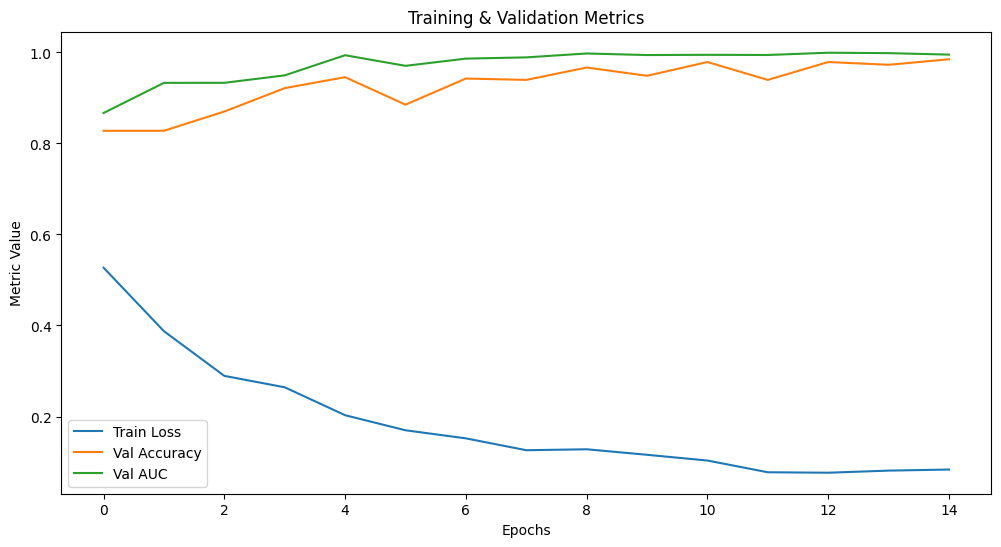

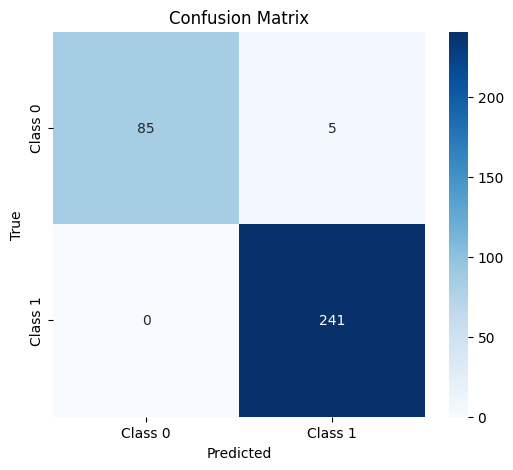

/tmp/ipython-input-3392281035.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


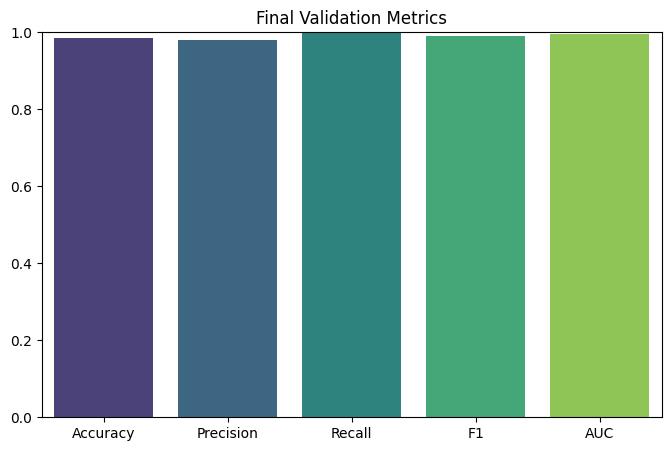


📌 Classification Report:

              precision    recall  f1-score   support

         0.0     1.0000    0.9444    0.9714        90
         1.0     0.9797    1.0000    0.9897       241

    accuracy                         0.9849       331
   macro avg     0.9898    0.9722    0.9806       331
weighted avg     0.9852    0.9849    0.9848       331



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Store training history
history = {
    "train_loss": [],
    "val_acc": [],
    "val_prec": [],
    "val_rec": [],
    "val_f1": [],
    "val_auc": []
}

def train_model(model, train_loader, val_loader, epochs=10):
    best_val_auc = 0.0
    model.to(device)  # move model to GPU/CPU

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # --- Training loop ---
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- Validation loop ---
        model.eval()
        y_true, y_pred, y_score = [], [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(imgs)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).int()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_score.extend(probs.cpu().numpy())

        # --- Metrics ---
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        auc = roc_auc_score(y_true, y_score)

        # Save to history
        history["train_loss"].append(train_loss / len(train_loader))
        history["val_acc"].append(acc)
        history["val_prec"].append(prec)
        history["val_rec"].append(rec)
        history["val_f1"].append(f1)
        history["val_auc"].append(auc)

        # --- Print epoch summary ---
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | "
              f"F1: {f1:.4f} | AUC: {auc:.4f}")

        # --- Save best model ---
        if auc > best_val_auc:
            best_val_auc = auc
            torch.save(model.state_dict(), "best_resnet50.pth")
            print(f"✅ Saved new best model (AUC: {best_val_auc:.4f})")

    return model, history

# Run training
model, history = train_model(model, train_loader, val_loader, epochs=15)


# -------------------------
# 📊 PLOTS AFTER TRAINING
# -------------------------

# 1. Training Curves
plt.figure(figsize=(12,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.plot(history["val_auc"], label="Val AUC")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.title("Training & Validation Metrics")
plt.legend()
plt.show()

# 2. Confusion Matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0","Class 1"], yticklabels=["Class 0","Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3. Bar plot of metrics
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
values = [history["val_acc"][-1], history["val_prec"][-1], history["val_rec"][-1], history["val_f1"][-1], history["val_auc"][-1]]

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0,1)
plt.title("Final Validation Metrics")
plt.show()

# 4. Classification Report
print("\n📌 Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))



📌 Test Classification Report:

              precision    recall  f1-score   support

         0.0     0.9953    0.9292    0.9611       226
         1.0     0.9740    0.9983    0.9860       601

    accuracy                         0.9794       827
   macro avg     0.9846    0.9638    0.9736       827
weighted avg     0.9798    0.9794    0.9792       827



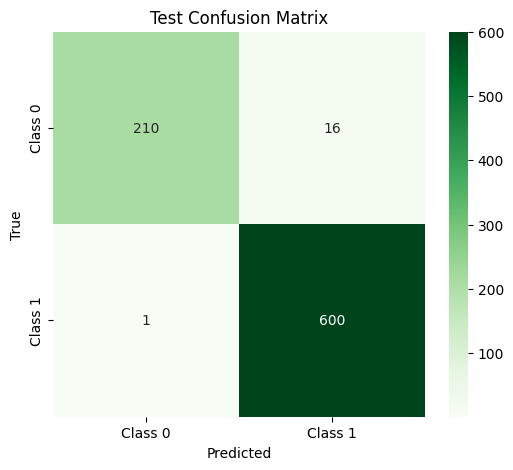

/tmp/ipython-input-3072498899.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="mako")


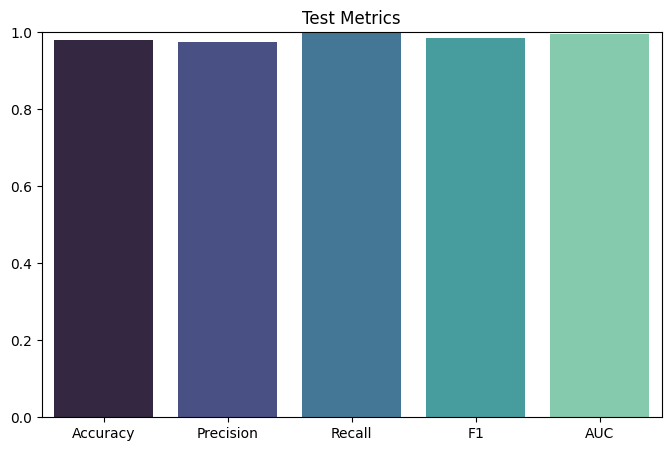

In [8]:
# -------------------------
# 🔎 TEST EVALUATION
# -------------------------
def evaluate_on_test(model, test_loader):
    model.eval()
    y_true, y_pred, y_score = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs.cpu().numpy())

    # --- Metrics ---
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_score)

    print("\n📌 Test Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=["Class 0","Class 1"],
                yticklabels=["Class 0","Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Test Confusion Matrix")
    plt.show()

    # --- Bar Plot of Test Metrics ---
    metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
    values = [acc, prec, rec, f1, auc]

    plt.figure(figsize=(8,5))
    sns.barplot(x=metrics, y=values, palette="mako")
    plt.ylim(0,1)
    plt.title("Test Metrics")
    plt.show()

    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc}


# Run test evaluation after training
test_results = evaluate_on_test(model, test_loader)



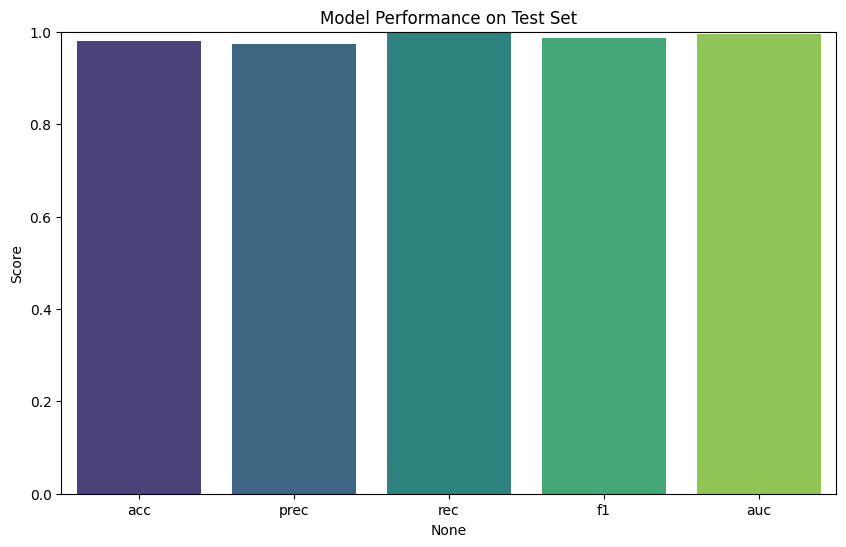

In [15]:
# -------------------------
# Merging of all the charts
# -------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_results dictionary is already available from the previous cell execution
# Example: test_results = {"acc": ..., "prec": ..., "rec": ..., "f1": ..., "auc": ...}

# Merge results into a DataFrame
all_results = pd.DataFrame({
    "Test": test_results
})

# Transpose so metrics are on x-axis
all_results = all_results.T  # rows = datasets, columns = metrics

# --- Plot ---
plt.figure(figsize=(10,6))
# Use seaborn barplot directly with explicit hue for future compatibility
sns.barplot(x=all_results.columns, y=all_results.iloc[0], palette="viridis", hue=all_results.columns, legend=False)
plt.title("Model Performance on Test Set")
plt.ylabel("Score")
plt.ylim(0,1)
# plt.legend(title="Metrics") # Legend is handled by hue in barplot
plt.xticks(rotation=0)
plt.show()

In [16]:
# Load best model
model.load_state_dict(torch.load("best_resnet50.pth"))
model.eval()

y_true, y_pred, y_score = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print("=== Final Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


=== Final Test Metrics ===
Accuracy: 0.9734
Precision: 0.9692
Recall: 0.9950
F1 Score: 0.9819
AUC: 0.9983


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


SAVE MODEL AND WEIGHTS


In [17]:
# SAVE

# Save weights
torch.save(model.state_dict(), '/content/drive/MyDrive/my_model_state_dict.pth')

#Saved Model
torch.save(model, '/content/drive/MyDrive/my_full_model.pth')



In [4]:
#Import Full Model
import torch

# Load full model object
model = torch.load('/content/drive/MyDrive/my_full_model.pth',weights_only=False   # 👈 Allow full unpickling
                   )

# Put in eval mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
!pip install grad-cam

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Choose the last conv layer in ResNet50 (before FC)
target_layer = model.layer4[-1]

# Initialize Grad-CAM++
cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

# Pick one test image
images, labels = next(iter(test_loader))
input_tensor = images[0].unsqueeze(0).to(device)  # single image
label = labels[0].item()

# Forward pass to get prediction
outputs = model(input_tensor)
# Assuming binary classification, get the probability of the positive class
probs = torch.sigmoid(outputs)
pred_class = (probs > 0.5).int().item()

# Run Grad-CAM++
# Use ClassifierOutputTarget(0) for binary output
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])
grayscale_cam = grayscale_cam[0, :]

# Convert input image back to [0,1] numpy (if normalized)
img = images[0].permute(1,2,0).cpu().numpy()
# Denormalize image for visualization if normalization was applied
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)


# Overlay heatmap
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Predicted: {pred_class}, True: {label}")
plt.axis('off')
plt.show()

IndexError: index 1 is out of bounds for dimension 0 with size 1